Have you ever wondered how computers tell apart images showing different categories in the "verify if you are human" questions? In this blog post, we'll explore image classification using Keras and TensorFlow datasets. We'll build a system that can distinguish between pictures of cats and dogs – similar to how these verification systems might identify cars, crosswalks, or traffic lights.

# Data Preparation
## Loading Packages and Obtaining Data

Let's import the necessary libraries for our project:


In [1]:
import os
import keras
from keras import utils
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

Let's first load the dataset. We’ll be using the `cats_vs_dogs` dataset from Kaggle, which contains labeled images of cats and dogs. We’ll split the dataset into training, validation, and test sets:

In [2]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 40% for training, 10% for validation, and 10% for test (the rest unused)
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


The dataset contains images of different sizes, which is problematic for neural networks that expect inputs of consistent dimensions. Let's resize all images to a fixed size of 150x150 pixels:

In [3]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

To ensure efficient training, we'll optimize our data pipeline:

In [4]:
from tensorflow import data as tf_data
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

## Understanding the Data Set
Before training a model, it’s important to understand the dataset. Let’s visualize some images to get a sense of what we’re working with. We’ll create a function to display three random cat images and three random dog images:

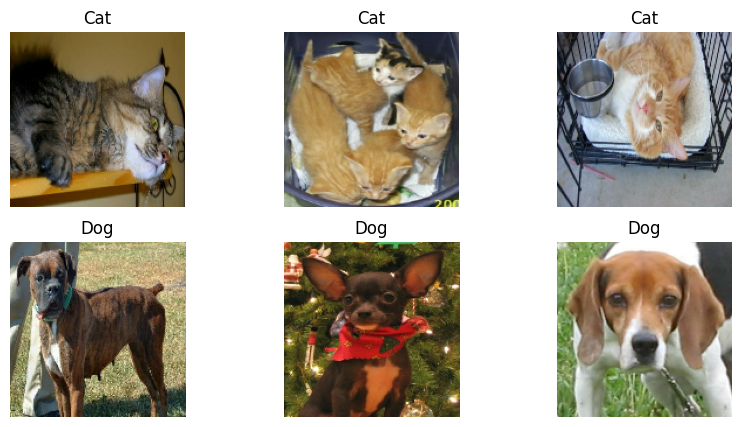

In [5]:
def visualize_cats_and_dogs(dataset):
    cat_images = []
    dog_images = []

    # retrive 3 images for cats and dogs each
    for images, labels in dataset.take(1): # take 1 batch
        for image, label in zip(images, labels):
            if label == 0 and len(cat_images) < 3:
                cat_images.append(image.numpy())
            elif label == 1 and len(dog_images) < 3:
                dog_images.append(image.numpy())
            if len(cat_images) == 3 and len(dog_images) == 3:
                break

    plt.figure(figsize=(10, 5))
    for i in range(3):
        plt.subplot(2, 3, i + 1)
        plt.imshow(cat_images[i] / 255.0)
        plt.title("Cat")
        plt.axis("off")

        plt.subplot(2, 3, i + 4)
        plt.imshow(dog_images[i] / 255.0)
        plt.title("Dog")
        plt.axis("off")

    plt.show()

visualize_cats_and_dogs(train_ds)

Next, it's also important for us to know the distribution of labels in the dataset. This helps us establish a baseline for our model, which is the model tat always guesses the most frequent label. We'll treat this as the benchmark for improvement.

Let’s compute the number of cat and dog images in the training set:

In [6]:
labels_iterator = train_ds.unbatch().map(lambda image, label: label).as_numpy_iterator()

cat_count = 0
dog_count = 0

for label in labels_iterator:
    if label == 0:
        cat_count += 1
    else:
        dog_count += 1

baseline_accuracy = max(cat_count, dog_count) / (cat_count + dog_count) * 100

print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")
print(f"Baseline accuracy: {baseline_accuracy:.2f}%")

Number of cat images: 4637
Number of dog images: 4668
Baseline accuracy: 50.17%


We see that the accuracy for our baseline model is 50.17%, indicating an even distribution of cats and dogs in our dataset.

For the next steps, our goal is to build a model that performs significantly better than this baseline.

# Basic CNN Model with Keras
Let's start by building our first convolutional neural network (CNN) model using Keras. We’ll include convolutional layers, pooling layers, and dropout layers to create a robust architecture. Finally, we’ll train the model and evaluate its performance.

In [7]:
from keras import layers, models

model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


After experimenting with different parameters for the model (using 2 conv2D and maxpooling layers, larger dropour rates), here is the number of parameters in each layer we are using for model 1, which achieves decent accuracy;

In [8]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model
Let's now train our model for 20 epochs.

In [9]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist1 = model1.fit(train_ds, epochs = 20, validation_data = validation_ds)


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.5511 - loss: 65.1645 - val_accuracy: 0.5989 - val_loss: 0.6488
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6032 - loss: 0.6564 - val_accuracy: 0.5675 - val_loss: 0.6751
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5822 - loss: 0.6688 - val_accuracy: 0.5469 - val_loss: 0.6793
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6097 - loss: 0.6501 - val_accuracy: 0.5615 - val_loss: 0.7137
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6397 - loss: 0.6075 - val_accuracy: 0.5353 - val_loss: 0.7725
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6781 - loss: 0.5726 - val_accuracy: 0.5817 - val_loss: 0.7848
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7060 - loss: 0.5297 - val_accuracy: 0.5899 - val_loss: 0.8211
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7358 - loss: 0.5205 - val_a

## Visualizing Model Accuracy
Now, let's visualize our model training results to better understand its accuracy. We’ll plot the training and validation accuracy to evaluate the model’s performance.


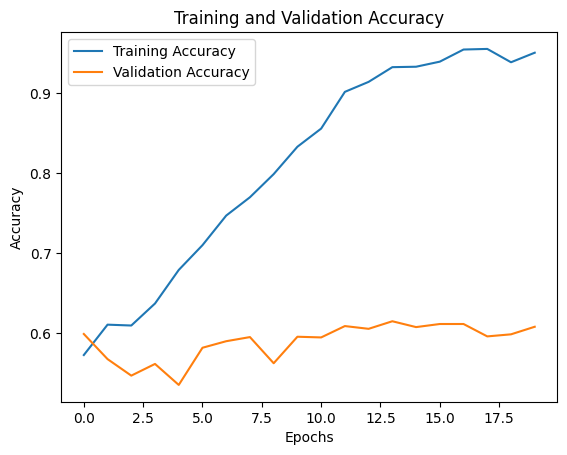

In [10]:
# Plot training and validation accuracy
def visualize_model_accuracy(history):
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()

visualize_model_accuracy(hist1)

**During training, the validation accuracy of the model stablizes between 55% to 60% during training.** It is slightly better than the baseline model by 5%.

However, overfitting is observed because the training accuracy keeps increasing while the validation accuracy stabilizes at a value well below it. This indicates that we have overfitted our model on the training data set such that it does not generalizes too well to the validation set.

# Model with Data Augmentation
In this section, we’ll improve our model by adding data augmentation layers. Data augmentation is a technique that artificially expands the training dataset by applying random transformations (e.g., flipping, rotating, zooming) to the images. This helps the model generalize better and reduces overfitting.

## Adding Data Augmentation Layers
We’ll use 2 argumentation layers:
- RandomFlip: Randomly flips images horizontally or vertically.
- RandomRotation: Randomly rotates images by a specified angle.

Let’s visualize the effect of these transformations on a sample image:

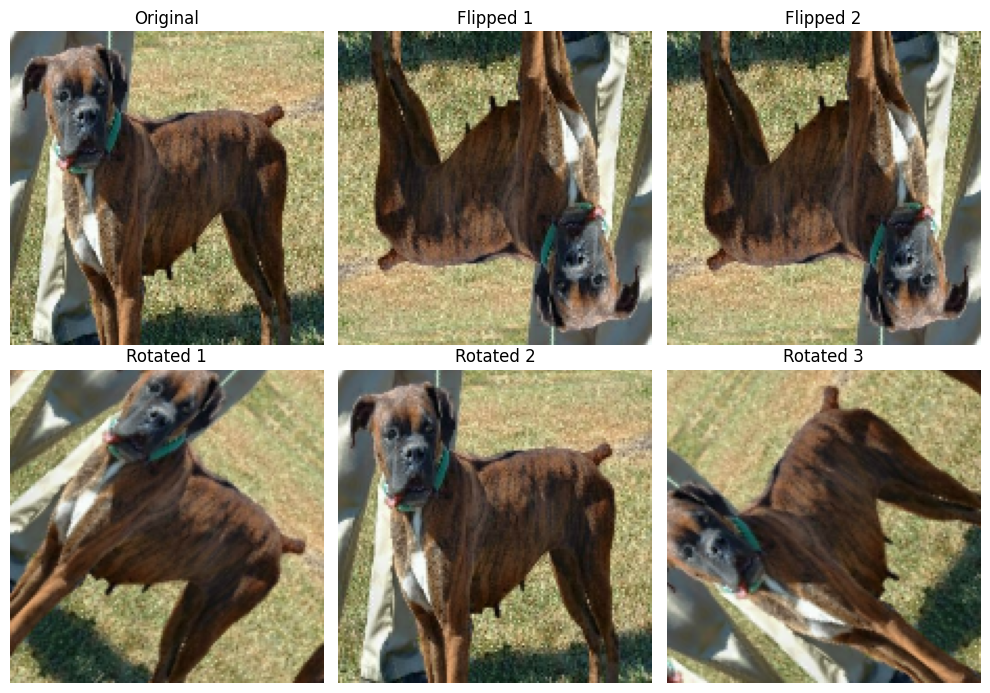

In [11]:
# Load a sample image
for images, labels in train_ds.take(1):
    sample_image = images[0].numpy()

# Define augmentation layers
flip_layer = layers.RandomFlip("horizontal_and_vertical")
rotate_layer = layers.RandomRotation(0.15)  # Rotate by up to 15%

# Apply augmentations
flipped_images = [flip_layer(sample_image) for _ in range(3)]
rotated_images = [rotate_layer(sample_image) for _ in range(3)]

# Plot the original, flipped, and rotated images
plt.figure(figsize=(10, 7))

# Row 1: Original and flipped images
plt.subplot(2, 3, 1)
plt.imshow(sample_image / 255.0)
plt.title("Original")
plt.axis("off")

for i, img in enumerate(flipped_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(img / 255.0)
    plt.title(f"Flipped {i + 1}")
    plt.axis("off")

# Row 2: Rotated images
for i, img in enumerate(rotated_images):
    plt.subplot(2, 3, i + 4)
    plt.imshow(img / 255.0)
    plt.title(f"Rotated {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Training the Model
Now, let’s create model 2 which includes the data augmentation layers. The architecture will be similar to model1, but with augmentation layers added at the beginning:

In [12]:
model2 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Data augmentation layers
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,600,193 (13.73 MB)

 Trainable params: 3,600,193 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

Now, let's train the model again for 20 epochs.

In [26]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist2 = model2.fit(train_ds, epochs = 20, validation_data = validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7088 - loss: 0.5668 - val_accuracy: 0.7373 - val_loss: 0.5510
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7267 - loss: 0.5535 - val_accuracy: 0.7494 - val_loss: 0.5028
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7331 - loss: 0.5422 - val_accuracy: 0.7485 - val_loss: 0.5093
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7326 - loss: 0.5315 - val_accuracy: 0.7403 - val_loss: 0.5217
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7527 - loss: 0.5178 - val_accuracy: 0.7730 - val_loss: 0.4758
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7675 - loss: 0.5017 - val_accuracy: 0.7592 - val_loss: 0.4877
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7662 - loss: 0.5031 - val_accuracy: 0.7635 - val_loss: 0.4870
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7670 - loss: 0.4931 - val_a

## Visualizing Model Accuracy

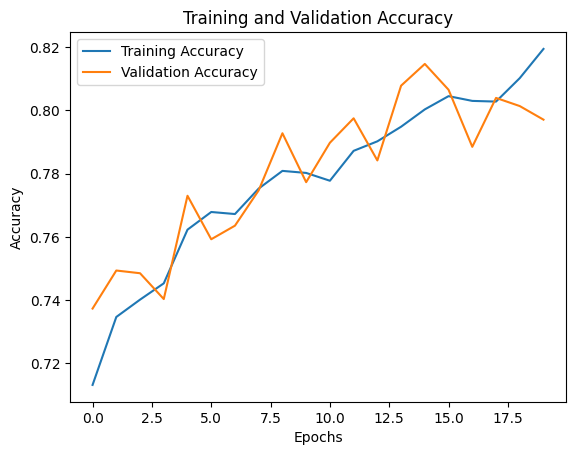

In [27]:
visualize_model_accuracy(hist2)

**During training, the validation accuracy of the model keeps increasing and stablizes between 75% and 80%**, which is about 20% better than model 1. There is not so much overfitting as the trends of the training and validation accuracy align very well.

# Data Preprocessing Model
Now, we’ll enhance our model by adding data preprocessing to normalize the pixel values of the images. Normalizing pixel values (e.g., scaling them to a range of 0 to 1 or -1 to 1) can help the model train faster and converge more effectively. We’ll incorporate this preprocessing step into our model pipeline.

In [15]:
def preprocess():
  i = keras.Input(shape=(150, 150, 3))
  # The pixel values have the range of (0, 255), but many models will work better if rescaled to (-1, 1.)
  # outputs: `(inputs * scale) + offset`
  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(i)
  preprocessor = keras.Model(inputs = i, outputs = x)
  return preprocessor

preprocess_layer = preprocess()

## Training the Model

In [16]:
model3 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Preprocessing layer
    preprocess_layer,

    # Data augmentation layers
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    # Fully connected layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,600,193 (13.73 MB)

 Trainable params: 3,600,193 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist3 = model3.fit(train_ds, epochs = 20, validation_data = validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8555 - loss: 0.3335 - val_accuracy: 0.8530 - val_loss: 0.3495
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8675 - loss: 0.3000 - val_accuracy: 0.8478 - val_loss: 0.3806
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8649 - loss: 0.3182 - val_accuracy: 0.8474 - val_loss: 0.3837
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8746 - loss: 0.2924 - val_accuracy: 0.8547 - val_loss: 0.3642
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8776 - loss: 0.2864 - val_accuracy: 0.8525 - val_loss: 0.3940
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8765 - loss: 0.2887 - val_accuracy: 0.8504 - val_loss: 0.3628
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8857 - loss: 0.2737 - val_accuracy: 0.8654 - val_loss: 0.3462
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8774 - loss: 0.2826 - val_ac

## Visualizing Model Accuracy

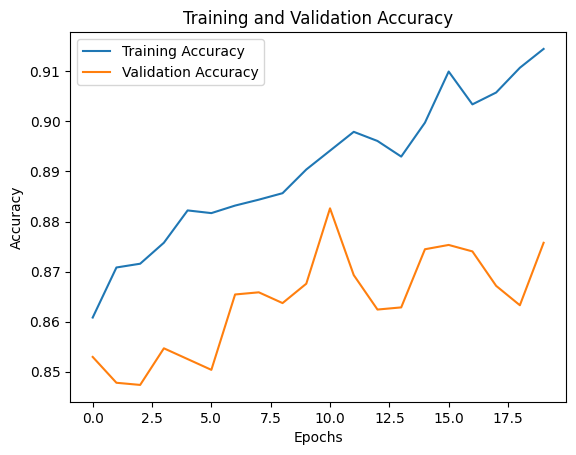

In [29]:
visualize_model_accuracy(hist3)

**During training, the validation accuracy of the model stablizes between 85% and 88%**, which is about 30% better than model 1. There is very little evidence of overfitting - the training accuracy is a little (about 0.02%) higher than the validation accuracy.

## Transfer Learning Model
Now, we’ll leverage transfer learning to build a highly accurate model for classifying cats and dogs. Transfer learning allows us to use a pre-trained model (trained on a large dataset like ImageNet) as a starting point for our task. This approach is especially useful when working with limited data, as it enables us to benefit from the features learned by the pre-trained model.

We’ll use `MobileNetV3Large`, a pre-trained model, as the base for our new model.

In [19]:
IMG_SHAPE = (150, 150, 3)
base_model = keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = keras.Model(inputs = i, outputs = x)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Training the Model
Now, let’s build model4 using data augmentation layers from previous models, `MobileNetV3Large` as the base model, and additional layers for classification.

In [20]:
model4 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Data augmentation layers
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),

    # Base model (MobileNetV3Large)
    base_model_layer,

    # Additional layers
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 5, 5, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 960)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In the summary of model 4, we notice that there are 2,996,352 non-trainable parameters, which are hidden in the base_model_layer. Therefore, we are only training 961 parameters here.

In [21]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist4 = model4.fit(train_ds, epochs = 20, validation_data = validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7008 - loss: 2.2544 - val_accuracy: 0.9518 - val_loss: 0.2481
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8775 - loss: 0.7049 - val_accuracy: 0.9630 - val_loss: 0.1839
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8905 - loss: 0.5860 - val_accuracy: 0.9656 - val_loss: 0.1699
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8991 - loss: 0.5048 - val_accuracy: 0.9678 - val_loss: 0.1544
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9126 - loss: 0.3838 - val_accuracy: 0.9673 - val_loss: 0.1413
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9134 - loss: 0.3689 - val_accuracy: 0.9695 - val_loss: 0.1227
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9145 - loss: 0.3188 - val_accuracy: 0.9652 - val_loss: 0.1169
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9151 - loss: 0.2863 - val_a

## Visualizing Model Accuracy


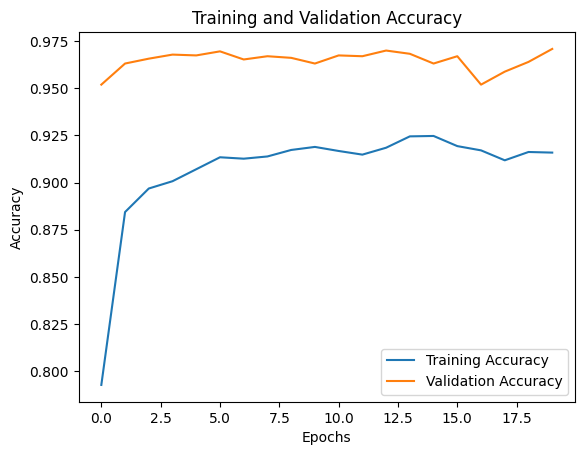

In [22]:
visualize_model_accuracy(hist4)

**During training, the validation accuracy of the model stablizes above 95%.** This is 30% better than model 1! There is little overfitting as the accuracy of the validation set exceeds that of the training set.

# Summary and Comparison
Now that we have built four different models, let's compare their results and evaluate their performance on the unseen test dataset. This will give us a clear understanding of how well our best model generalizes to new data.

Let's compare their validation accuracy on the same plot:

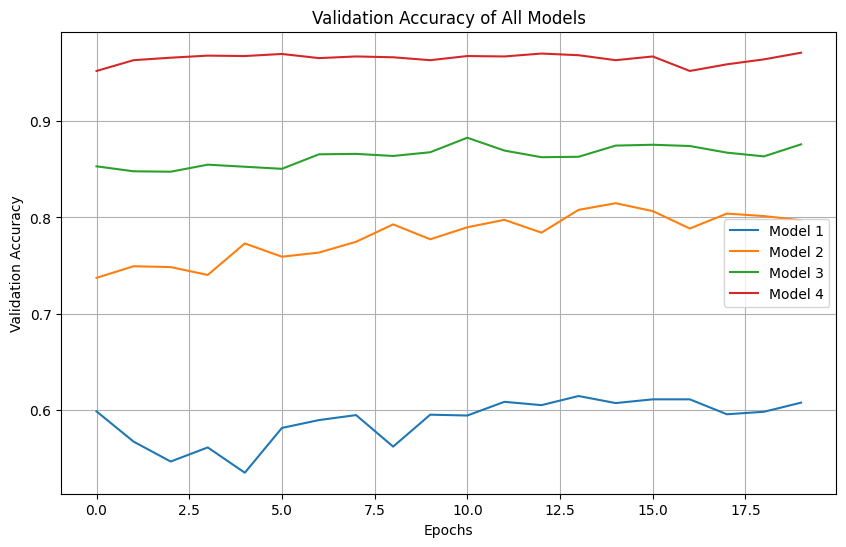

In [30]:
# Plot validation accuracy for all models
plt.figure(figsize=(10, 6))

plt.plot(hist1.history['val_accuracy'], label='Model 1')
plt.plot(hist2.history['val_accuracy'], label='Model 2')
plt.plot(hist3.history['val_accuracy'], label='Model 3')
plt.plot(hist4.history['val_accuracy'], label='Model 4')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy of All Models')
plt.legend()
plt.grid(True)
plt.show()

We see that the validation accuracy of model 4, the transfer learning model, achieves the highest validation accuracy and is well above other models.

Let's also test the performance of the four models on the test set:

In [31]:
# Evaluate model1 on the test set
test_loss1, test_accuracy1 = model1.evaluate(test_ds)
print(f"Model 1 - Test Accuracy: {test_accuracy1 * 100:.2f}%")

# Evaluate model2 on the test set
test_loss2, test_accuracy2 = model2.evaluate(test_ds)
print(f"Model 2 - Test Accuracy: {test_accuracy2 * 100:.2f}%")

# Evaluate model3 on the test set
test_loss3, test_accuracy3 = model3.evaluate(test_ds)
print(f"Model 3 - Test Accuracy: {test_accuracy3 * 100:.2f}%")

# Evaluate model4 on the test set
test_loss4, test_accuracy4 = model4.evaluate(test_ds)
print(f"Model 4 - Test Accuracy: {test_accuracy4 * 100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5920 - loss: 1.9361
Model 1 - Test Accuracy: 60.32%
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7996 - loss: 0.4432
Model 2 - Test Accuracy: 80.14%
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8751 - loss: 0.3511
Model 3 - Test Accuracy: 86.76%
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9625 - loss: 0.1157
Model 4 - Test Accuracy: 95.83%


We see that the test accuracy for model 4 is 95.83%, well above that for other models that we built from scratch. This shows that transfer learning might be a really effective approach in model training!